In [1]:
import os
import ee
import geopandas as gpd
import numpy as np

import rasterio
from matplotlib import pyplot as plt
from skimage.transform import resize
from skimage.exposure import rescale_intensity

from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm.notebook import tqdm

In [2]:
from src.data.fetch import dem_from_tnm, landtrendr_from_gee, s2_from_gee, nlcd_from_mrlc
from src.visualization.utils import colorize_nlcd

In [3]:
ee.Authenticate()

Enter verification code:  4/1AX4XfWgqC5XmHZBj-MNSKmiSrtnxDPh6iuYrwzwn8KoJ5Ey6FjkkV7Owpjg



Successfully saved authorization token.


In [4]:
ee.Initialize()

In [5]:
tiles = gpd.read_file('../data/interim/oregon_quarter_quads.shp')
tiles.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7508 entries, 0 to 7507
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   CELL_ID     7508 non-null   int64   
 1   CELL_NAME   7508 non-null   object  
 2   PRIMARY_ST  7508 non-null   object  
 3   CELL_MAPCO  7508 non-null   object  
 4   CELL_TYPE   7508 non-null   int64   
 5   CELL_ALLWA  7508 non-null   int64   
 6   CELL_DESCR  0 non-null      object  
 7   CELL_DIACR  0 non-null      object  
 8   GLOBALID    7508 non-null   object  
 9   SHAPE_Leng  7508 non-null   float64 
 10  SHAPE_Area  7508 non-null   float64 
 11  geometry    7508 non-null   geometry
dtypes: float64(2), geometry(1), int64(3), object(6)
memory usage: 704.0+ KB


## An Illustrative Example
For a single tile, fetch the SENTINEL-2, LandTrendr, DEM, and NLCD imagery and plot it.

In [7]:
tile = tiles.sample(1)
bbox = tile.iloc[0]['geometry'].bounds
epsg = tiles.crs.to_epsg()
tile.iloc[0]

CELL_ID                                                  171632
CELL_NAME                                    Grassy Mountain SE
PRIMARY_ST                                               Oregon
CELL_MAPCO                                             43117-F3
CELL_TYPE                                                     1
CELL_ALLWA                                                    2
CELL_DESCR                                                 None
CELL_DIACR                                                 None
GLOBALID                 {5EC51477-D397-11DE-9C20-00144F233E68}
SHAPE_Leng                                                 0.25
SHAPE_Area                                             0.003906
geometry      POLYGON ((2172543.7674758807 700505.4100057733...
Name: 3316, dtype: object

In [8]:
%%time
s2_ras, s2_profile = s2_from_gee(bbox, 2021, epsg, scale=10)
width, height = s2_profile['width'], s2_profile['height']

CPU times: user 169 ms, sys: 64.2 ms, total: 234 ms
Wall time: 18.5 s


In [9]:
%%time
lt_ras, lt_profile = landtrendr_from_gee(bbox, 2021, epsg, scale=30)
lt_ras = resize(lt_ras, (lt_ras.shape[0], s2_ras.shape[1], s2_ras.shape[2]), order=0, preserve_range=True)

CPU times: user 2.45 s, sys: 141 ms, total: 2.59 s
Wall time: 48.9 s


In [10]:
%%time
dem = dem_from_tnm(bbox, width=width, height=height, inSR=epsg, pixelType='S16')

CPU times: user 59.3 ms, sys: 22.2 ms, total: 81.5 ms
Wall time: 892 ms


In [11]:
%%time
nlcd = nlcd_from_mrlc(bbox, width=width, height=height, layer='NLCD_2019_Land_Cover_L48', inSR=epsg)
nlcd_color = colorize_nlcd(nlcd)

CPU times: user 55.8 ms, sys: 8.45 ms, total: 64.2 ms
Wall time: 899 ms


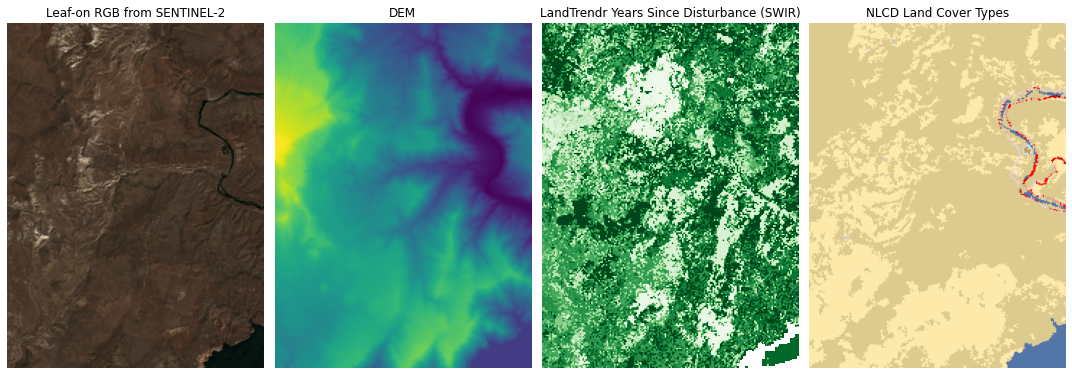

In [17]:
fig, axs = plt.subplots(1,4, figsize=(15,10))
axs[0].imshow(rescale_intensity(
    np.dstack((s2_ras[8], s2_ras[7], s2_ras[6])), 
#     in_range=(0,2000),
    out_range='uint8'))
axs[1].imshow(dem)
axs[2].imshow(np.ma.masked_equal(lt_ras[0], -32768), cmap='Greens')
axs[3].imshow(nlcd_color)
for ax in axs.ravel():
    ax.axis('off')
axs[0].set_title('Leaf-on RGB from SENTINEL-2')
axs[1].set_title('DEM')
axs[2].set_title('LandTrendr Years Since Disturbance (SWIR)')
axs[3].set_title('NLCD Land Cover Types')
plt.tight_layout()
plt.show()

## Download Data for Tiles in Oregon
With a helper function to download images, we'll iterate through all the tiles and fetch the data with some parallel processing.

In [13]:
def download_images(gdf_row, out_dir='../data/interim/oregon_imagery', 
                    overwrite=False, epsg=2992, year=2021):
    bbox = gdf_row['geometry'].bounds
    cell_id = gdf_row['CELL_ID']
    
    # get sentinel image and save to disk
    out_s2 = os.path.join(out_dir, 'sentinel', f'{cell_id}_sentinel.tif')
    if not os.path.exists(out_s2) or overwrite:
        s2_ras, s2_profile = s2_from_gee(bbox, year, epsg, scale=10)
        s2_profile.update(compress='LZW')
        
        with rasterio.open(out_s2, 'w', **s2_profile) as dst:
            for i, band in enumerate(s2_ras):
                dst.write(band, i+1)
    
    # get landtrendr image, resize, and save to disk, enforce same size as sentinel image
    with rasterio.open(out_s2) as src:
        width, height, trf, crs = src.width, src.height, src.transform, src.crs
    
    out_lt = os.path.join(out_dir, 'landtrendr', f'{cell_id}_landtrendr.tif')
    if not os.path.exists(out_lt) or overwrite:
        lt_ras, lt_profile = landtrendr_from_gee(bbox, 2021, epsg, scale=30)
        lt_ras = resize(lt_ras, (lt_ras.shape[0], height, width), order=0, preserve_range=True)
        lt_profile.update(width=width, height=height, transform=trf, compress='LZW')
        
        with rasterio.open(out_lt, 'w', **lt_profile) as dst:
            for i, band in enumerate(lt_ras):
                dst.write(band, i+1)
    
    # get dem, enforce same size as sentinel image
    out_dem = os.path.join(out_dir, 'dem', f'{cell_id}_dem.tif')
    if not os.path.exists(out_dem) or overwrite:
        dem = dem_from_tnm(bbox, width=width, height=height, inSR=epsg, pixelType='S16')
        dem_profile = {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 
                       'width': width, 'height': height, 'count': 1, 'crs': crs, 
                       'transform': trf, 'blockxsize': 256, 'blockysize': 256, 
                       'tiled': True, 'compress': 'LZW', 'interleave': 'pixel'}
        with rasterio.open(out_dem, 'w', **dem_profile) as dst:
            dst.write(dem, 1)
            
    # get nlcd from 2019, enforce same size as sentinel image
    out_nlcd = os.path.join(out_dir, 'nlcd', f'{cell_id}_nlcd.tif')
    if not os.path.exists(out_nlcd) or overwrite:
        nlcd = nlcd_from_mrlc(bbox, width=width, height=height, layer='NLCD_2019_Land_Cover_L48', inSR=epsg)
        nlcd_profile = {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0, 
                       'width': width, 'height': height, 'count': 1, 'crs': crs, 
                       'transform': trf, 'blockxsize': 256, 'blockysize': 256, 
                       'tiled': True, 'compress': 'LZW', 'interleave': 'pixel'}
        with rasterio.open(out_nlcd, 'w', **nlcd_profile) as dst:
            dst.write(nlcd, 1)
            dst.write_colormap(
                1, {
                    0: [0, 0, 0],  # nodata
                    11: [84, 117, 168],  # open water
                    12: [255, 255, 255],  # perennial ice and snow
                    21: [232, 209, 209],  # developed, open space
                    22: [226, 158, 140],  # developed, low intensity
                    23: [255, 0, 0],  # developed, medium intensity
                    24: [181, 0, 0],  # developed, high intensity
                    31: [210, 205, 192],  # barren land (rock/sand/clay)
                    41: [133, 199, 126],  # deciduous forest
                    42: [56, 129, 78],  # evergreen forest
                    43: [212, 231, 176],  # mixed forest
                    51: [175, 150, 60],  # dwarf scrub
                    52: [220, 202, 143],  # shrub/scrub
                    71: [253, 233, 170],  # grassland/herbaceous
                    72: [209, 209, 130],  # sedge/herbaceous
                    73: [163, 204, 81],  # lichens
                    74: [130, 186, 158],  # moss
                    81: [251, 246, 93],  # pasture/hay
                    82: [202, 145, 70],  # cultivated crops
                    90: [200, 230, 248],  # woody wetlands
                    95: [100, 179, 213],  # emergent herbaceous wetlands
                })
    
    return cell_id

In [14]:
to_run = [row for _, row in tiles[['geometry', 'CELL_ID']].iterrows()]
to_run[0]['CELL_ID']

221801

In [15]:
OUT_DIR = '../data/interim/oregon_imagery'
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, 'sentinel'), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, 'landtrendr'), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, 'dem'), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, 'nlcd'), exist_ok=True)

In [16]:
with ProcessPoolExecutor(3) as executor:
    completed = []
    jobs = [executor.submit(download_images, row) for row in to_run[0:6]]
    
    for job in tqdm(as_completed(jobs), total=len(jobs)):
        completed.append(job.result())        

  0%|          | 0/6 [00:00<?, ?it/s]